In [5]:
# Install required packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import plotly.express as px

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')


In [3]:
df = pd.read_csv("/TRAIN (1).csv")
df.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             188340 non-null  object 
 1   Store_id       188340 non-null  int64  
 2   Store_Type     188340 non-null  object 
 3   Location_Type  188340 non-null  object 
 4   Region_Code    188340 non-null  object 
 5   Date           188340 non-null  object 
 6   Holiday        188340 non-null  int64  
 7   Discount       188340 non-null  object 
 8   #Order         188340 non-null  int64  
 9   Sales          188340 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 14.4+ MB


In [6]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,188340,188340,T1188340,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Store_id,188340.0,NaN,NaN,NaN,183.0,105.366308,1.0,92.0,183.0,274.0,365.0
Store_Type,188340,4,S1,88752,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Location_Type,188340,5,L1,85140,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Region_Code,188340,4,R1,63984,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date,188340,516,2019-05-31,365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Holiday,188340.0,NaN,NaN,NaN,0.131783,0.338256,0.0,0.0,0.0,0.0,1.0
Discount,188340,2,No,104051,NaN,NaN,NaN,NaN,NaN,NaN,NaN
#Order,188340.0,NaN,NaN,NaN,68.205692,30.467415,0.0,48.0,63.0,82.0,371.0
Sales,188340.0,NaN,NaN,NaN,42784.327982,18456.708302,0.0,30426.0,39678.0,51909.0,247215.0


In [7]:
df.isna().sum()

,0
ID,0
Store_id,0
Store_Type,0
Location_Type,0
Region_Code,0
Date,0
Holiday,0
Discount,0
#Order,0
Sales,0


In [8]:
df.columns = df.columns.str.strip()

In [9]:
# Parse date
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    # Extract features
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['Weekday'] = df['Date'].dt.day_name()
else:
    print("No Date column found — please ensure dataset has 'Date' column")

In [10]:
# Ensure categorical fields are strings
for c in ['Store_Type','Location_Type','Discount','Region_Code']:
    if c in df.columns:
        df[c] = df[c].astype(str).fillna('NA')

In [11]:
# Fill simple missing numeric values with median
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

df.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales,Year,Month,Day,Weekday
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84,2018,1,1,Monday
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12,2018,1,1,Monday
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20,2018,1,1,Monday
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16,2018,1,1,Monday
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52,2018,1,1,Monday


Univariate Distributions

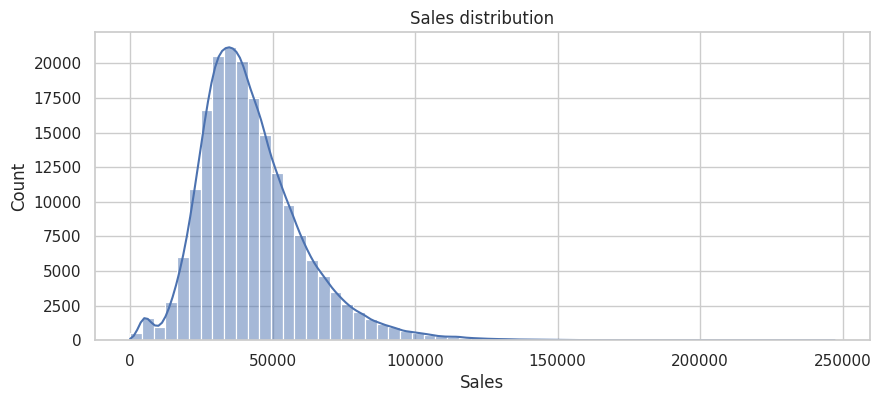

In [12]:
# Sales distribution
plt.figure(figsize=(10,4))
sns.histplot(df['Sales'], kde=True, bins=60)
plt.title('Sales distribution')
plt.show()

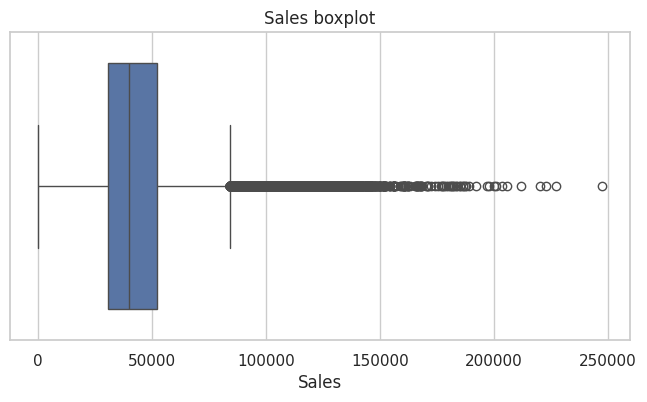

In [13]:
# Boxplot for sales
plt.figure(figsize=(8,4))
sns.boxplot(x=df['Sales'])
plt.title('Sales boxplot')
plt.show()

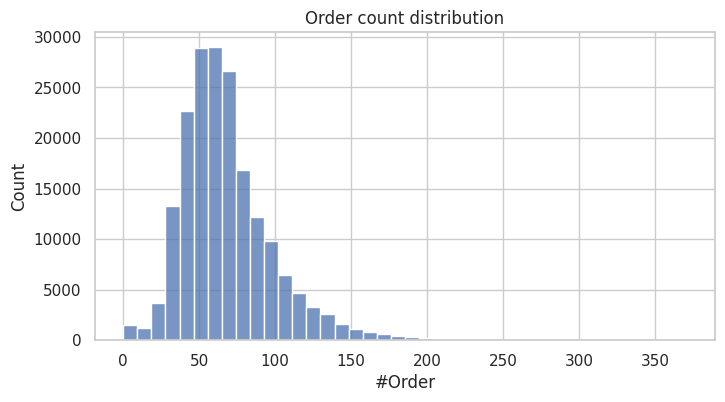

In [14]:
# Orders distribution
if '#Order' in df.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(df['#Order'], bins=40)
    plt.title('Order count distribution')
    plt.show()

Time Series Aggregate

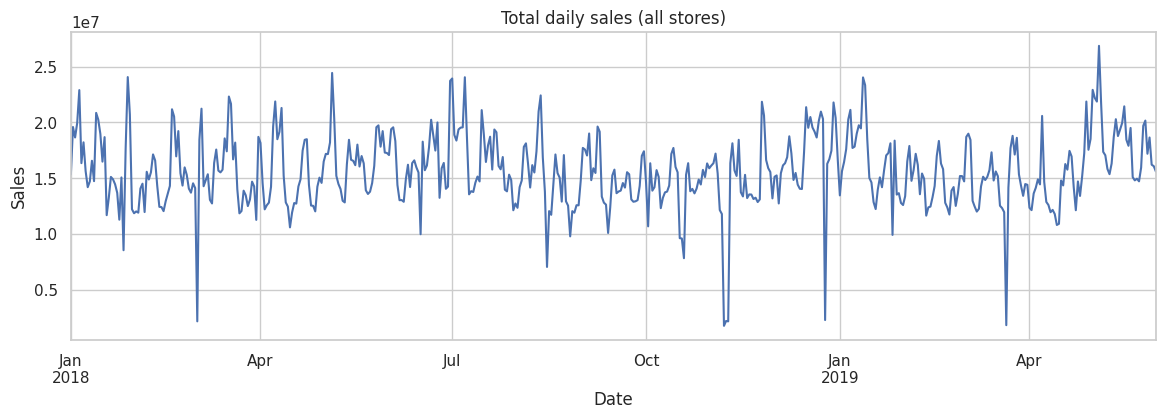

In [15]:
# Aggregate to daily sales (if multiple stores per date)
ts = df.groupby('Date')['Sales'].sum().sort_index()
plt.figure(figsize=(14,4))
ts.plot()
plt.title('Total daily sales (all stores)')
plt.ylabel('Sales')
plt.show()

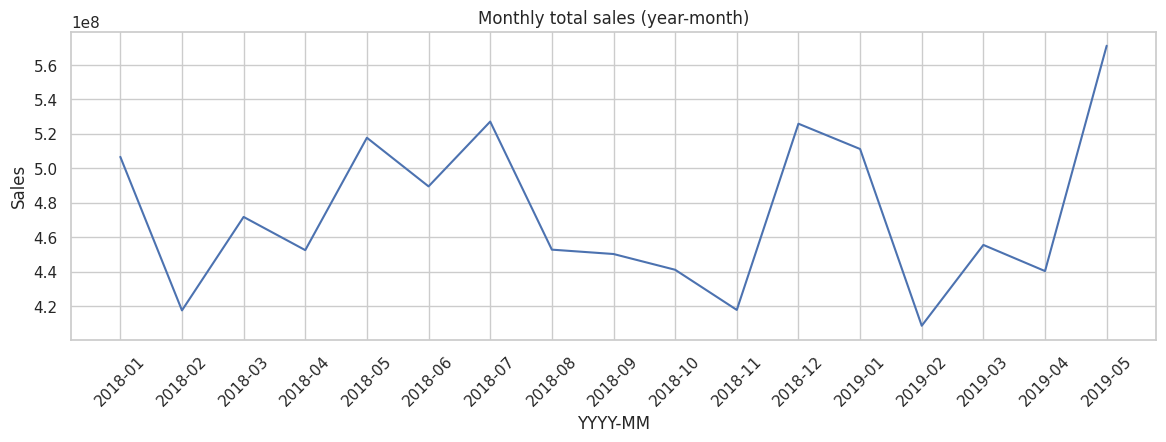

In [16]:
# Quick seasonal check by month
monthly = df.groupby(['Year','Month'])['Sales'].sum().reset_index()
monthly['YYYY-MM'] = monthly['Year'].astype(str) + '-' + monthly['Month'].astype(str).str.zfill(2)
plt.figure(figsize=(14,4))
sns.lineplot(data=monthly, x='YYYY-MM', y='Sales')
plt.xticks(rotation=45)
plt.title("Monthly total sales (year-month)")
plt.show()

Categorical Analysis

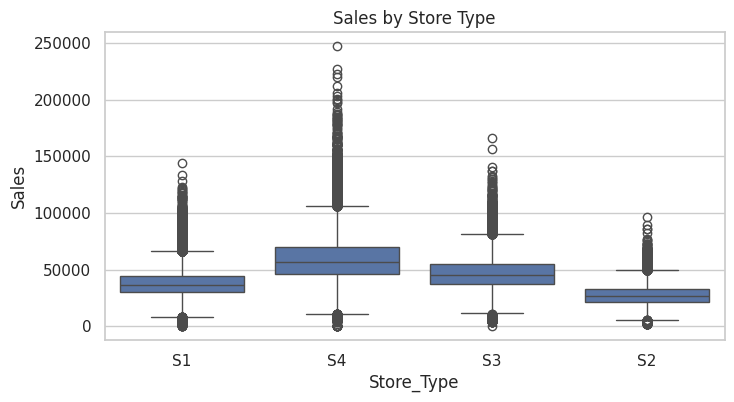

In [17]:
# Sales by Store Type
if 'Store_Type' in df.columns:
    plt.figure(figsize=(8,4))
    sns.boxplot(data=df, x='Store_Type', y='Sales')
    plt.title('Sales by Store Type')
    plt.show()

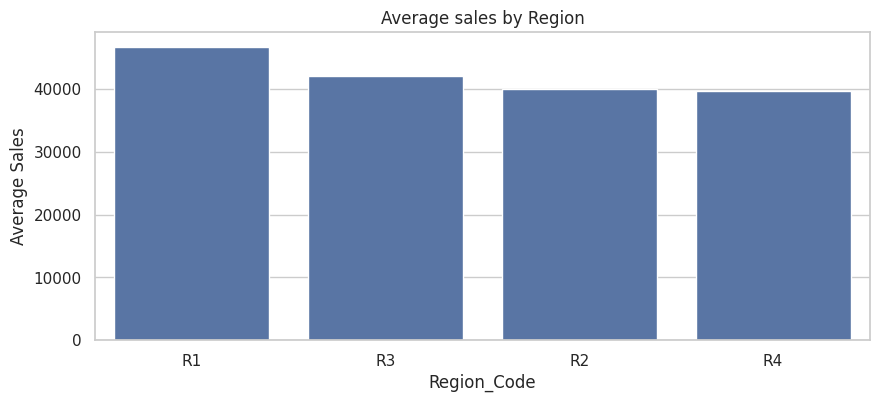

In [18]:
# Mean sales by region
if 'Region_Code' in df.columns:
    reg = df.groupby('Region_Code')['Sales'].mean().sort_values(ascending=False)
    plt.figure(figsize=(10,4))
    sns.barplot(x=reg.index, y=reg.values)
    plt.title('Average sales by Region')
    plt.ylabel('Average Sales')
    plt.show()

#### Correlation

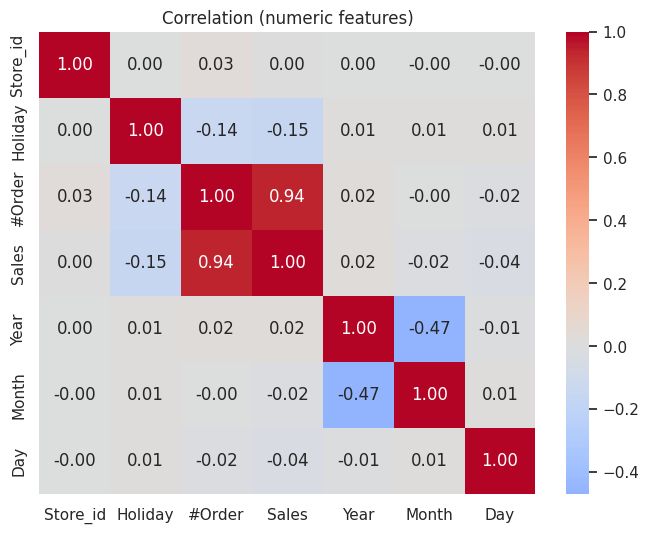

In [19]:
corr_cols = ['Sales']
if '#Order' in df.columns:
    corr_cols.append('#Order')
num = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(8,6))
sns.heatmap(df[num].corr(), annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation (numeric features)')
plt.show()

## **Hypothesis Testing**

Discount Effect

In [20]:
# Discount Yes vs No (t-test)
if 'Discount' in df.columns:
    disc_yes = df[df['Discount'].str.lower().isin(['yes','y','true','1'])]['Sales']
    disc_no = df[~df['Discount'].str.lower().isin(['yes','y','true','1'])]['Sales']
    print("Counts:", len(disc_yes), len(disc_no))

    t_stat, p_val = stats.ttest_ind(disc_yes, disc_no, equal_var=False, nan_policy='omit')
    print(f"Discount t-stat: {t_stat:.4f}, p-value: {p_val:.4f}")
    if p_val < 0.05:
        print("Reject H0: sales differ on discount days")
    else:
        print("Fail to reject H0: no significant difference")
else:
    print("No Discount column to test.")


Counts: 84289 104051
Discount t-stat: 145.9295, p-value: 0.0000
Reject H0: sales differ on discount days


Holiday Effect

In [21]:
# Holiday effect
if 'Holiday' in df.columns:
    hol = df[df['Holiday'].isin([1,'1',True,'True'])]['Sales']
    nonhol = df[~df['Holiday'].isin([1,'1',True,'True'])]['Sales']
    t_stat, p_val = stats.ttest_ind(hol, nonhol, equal_var=False, nan_policy='omit')
    print(f"Holiday t-stat: {t_stat:.4f}, p-value: {p_val:.4f}")
else:
    print("No Holiday column present")


Holiday t-stat: -66.1758, p-value: 0.0000


ANOVA across store types

In [22]:
# ANOVA: sales across store types
if 'Store_Type' in df.columns:
    grp = [g['Sales'].values for _, g in df.groupby('Store_Type')]
    fstat, pval = stats.f_oneway(*grp)
    print(f"ANOVA F-stat: {fstat:.4f}, p-value: {pval:.4f}")
    if pval < 0.05:
        print("Significant differences — run Tukey HSD")
        tuk = pairwise_tukeyhsd(df['Sales'], df['Store_Type'])
        print(tuk.summary())
else:
    print("No Store_Type column")


ANOVA F-stat: 35123.6441, p-value: 0.0000
Significant differences — run Tukey HSD
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2   meandiff  p-adj    lower      upper    reject
-------------------------------------------------------------
    S1     S2 -10145.6835   0.0 -10402.8539  -9888.513   True
    S1     S3   9386.5565   0.0   9113.6974  9659.4156   True
    S1     S4  22269.1742   0.0  22050.9148 22487.4336   True
    S2     S3    19532.24   0.0  19203.4535 19861.0265   True
    S2     S4  32414.8577   0.0  32129.7514 32699.9641   True
    S3     S4  12882.6177   0.0  12583.2834 13181.9521   True
-------------------------------------------------------------


## **Prepare Features for ML**

In [23]:
# Select features and target (adjust these if your dataset uses different names)
features = ['Store_id','Store_Type','Location_Type','Region_Code','Discount','Holiday','#Order','Year','Month','Day']
# Keep only existing ones
features = [f for f in features if f in df.columns]
X = df[features].copy()
y = df['Sales'].copy()

# Handle missing & types
for c in X.select_dtypes(include=['object']).columns:
    X[c] = X[c].fillna('NA')

for c in X.select_dtypes(include=[np.number]).columns:
    X[c] = X[c].fillna(X[c].median())

Column Transformer and Model Training

In [25]:
categorical = X.select_dtypes(include=['object']).columns.tolist()
numerical = X.select_dtypes(include=[np.number]).columns.tolist()

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('num', StandardScaler(), numerical)
], remainder='drop')

# Train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = Pipeline([
    ('prep', preprocessor),
    ('model', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
])

rf.fit(X_train, y_train)
pred = rf.predict(X_test)

print("MAE:", mean_absolute_error(y_test, pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred)))
print("R2:", r2_score(y_test, pred))

MAE: 1932.7887059254538
RMSE: 2922.0959520943056
R2: 0.9747433108689407


In [26]:
lr = Pipeline([
    ('prep', preprocessor),
    ('model', LinearRegression())
])
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)
print("LR MAE:", mean_absolute_error(y_test, pred_lr))
print("LR RMSE:", np.sqrt(mean_squared_error(y_test, pred_lr)))
print("LR R2:", r2_score(y_test, pred_lr))

LR MAE: 3669.872522799827
LR RMSE: 5081.382537743571
LR R2: 0.9236249943983279


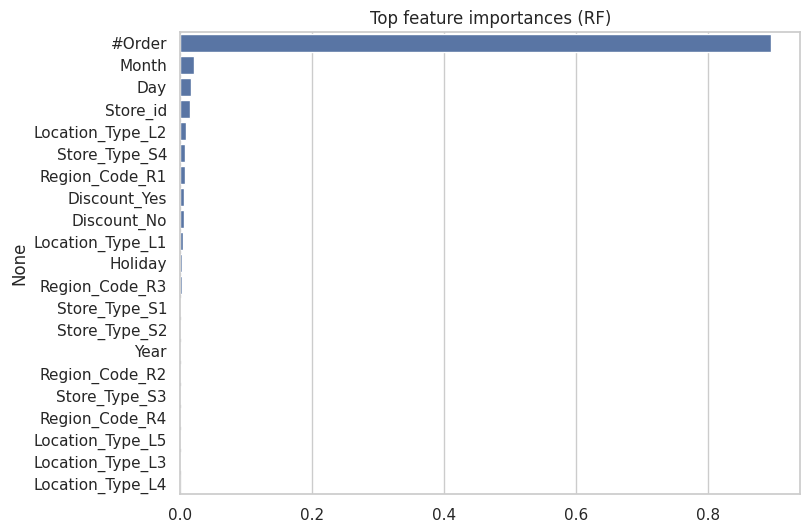

In [27]:
# For RF - map back feature importances
ohe = rf.named_steps['prep'].named_transformers_['cat']
ohe_feature_names = []
if hasattr(ohe, 'get_feature_names_out'):
    ohe_feature_names = list(ohe.get_feature_names_out(categorical))
else:
    # fallback
    for c in categorical:
        vals = X[c].unique().tolist()
        ohe_feature_names += [f"{c}_{v}" for v in vals]

num_feature_names = numerical
feature_names = ohe_feature_names + num_feature_names

importances = rf.named_steps['model'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(25)
plt.figure(figsize=(8,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Top feature importances (RF)")
plt.show()

Save Model

In [28]:
os.makedirs('models', exist_ok=True)
joblib.dump(rf, "models/sales_forecast_model.pkl")
print("Model saved to models/sales_forecast_model.pkl")

Model saved to models/sales_forecast_model.pkl


Quick inference example

In [29]:
sample = X_test.iloc[0:1]
print(sample)
pred_sample = rf.predict(sample)
print("Predicted sales:", pred_sample[0], "Actual:", y_test.iloc[0])

      Store_id Store_Type Location_Type Region_Code Discount  Holiday  #Order  \
2393       287         S1            L4          R1       No        0      54   

      Year  Month  Day  
2393  2018      1    7  
Predicted sales: 34081.9992 Actual: 32667.0
